## The Problem Statment

### Project Summary:


According to the World Health Organisation (WHO), stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
The dataset provided is used to predict whether a patient is likely to get a stroke based on input parameters like gender, age, various diseases and smoking status.
Below is the information regarding the dataset attributes:
1) id: unique patient identifier
2) gender: “Male”, “Female” or “Other”
3) age: age of the patient
4) hypertension: 0 (if the patient doesn’t have hypertension) or 1 (if the patient has
hypertension)
5) heart_disease: 0 (if the patient doesn’t have a heart disease) or 1 (if the patient has
a heart disease)
6) ever_married: “No” or “Yes”
7) work_type: “children”, “Govt_job”, “Never_worked”, “Private” or “Self-employed”
8) Residence_type: “Rural” or “Urban”
9) avg_glucose_level: average glucose level in the blood
10) bmi: body mass index
11) smoking_status: “formerly smoked”, “never smoked”, “smokes” or “Unknown” (in this case the information for the patient is not available)
12) stroke: 1 (if the patient had a stroke) or 0 (if the patient didn’t have a stroke)
 
<b> Project Objectives: </b>

Using the provided dataset, the goal is to train a model that predicts whether a patient has a stroke or not. This Jupyter Notebook includes exploratory analysis of the data, feature engineering and selection, model training and evaluation.


### Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

### Reading Input data

In [2]:
# saving the dataset as a dataframe in `df` with `id` as index, and keeping a copy of the raw dataset
df = pd.read_csv("../data/stroke_data.csv",sep=",",index_col="id")
raw_df = df.copy()

### Dataset details

In [3]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [5]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# checking for missing values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

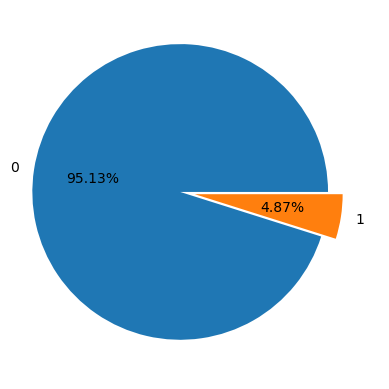

In [7]:
plt.pie(raw_df.stroke.value_counts(),labels=raw_df.stroke.value_counts().index,autopct='%1.2f%%',explode=[0.1,0])
plt.show()

In a dataset of 5110  entries, we have 201 missing records which appear online in the `bmi` field. We also see that the data is highly unbalanced and unfavorable for our target class which is patients with stroke. Roughly 95% of patients recorded in this dataset do not have stroke. We will attempt to balance this later in this notebook.

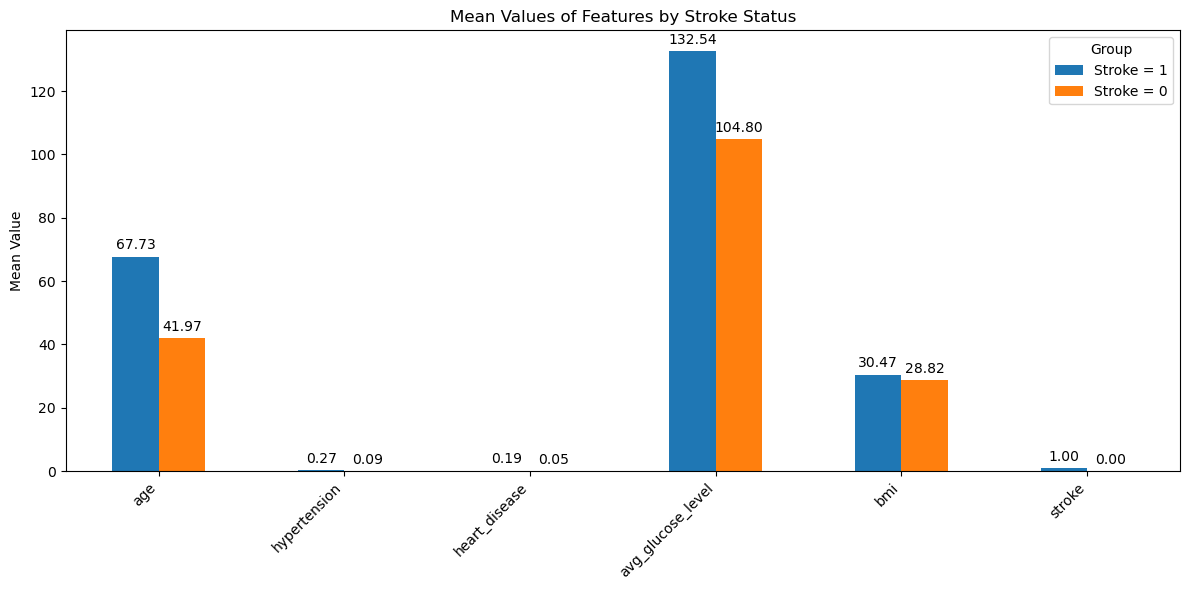

In [8]:
# separate target class of patients with stroke from those without and calculate the mean
means_stroke = raw_df[raw_df['stroke'] == 1].mean(numeric_only=True)
means_no_stroke = raw_df[raw_df['stroke'] == 0].mean(numeric_only=True)

means_df = pd.DataFrame({
    'Stroke = 1': means_stroke,
    'Stroke = 0': means_no_stroke
})

ax = means_df.plot(kind='bar', figsize=(12, 6))
plt.title("Mean Values of Features by Stroke Status")
plt.ylabel("Mean Value")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Group")

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",   
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom',
        xytext=(0, 3), textcoords='offset points'
    )

plt.tight_layout()
plt.show()


Here we have a plot of the mean values of all features group by patients with and without stroke.
We see on average, the feature for patients with stroke is typically higher than those without. This is especially so for age and average glucose levels probably indicating age and glucose levels affects stroke likelihood.

## EDA and Feature Engineering

### Visually Explaining the Data

In [9]:
df.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Given that the number of unique values within `age`, `avg_glucose_level` and `bmi` exceeds a reasonable amount that allows for splitting into categories, we consider them numerical columns.

In [10]:
# identify the numerical(discrete/continous) and categorical(ordinal) features
num_cols = ["age", "avg_glucose_level", "bmi"]
cat_cols = ["gender", "hypertension", "heart_disease", \
            "ever_married", "work_type", "Residence_type", "smoking_status"]

In [11]:
(3 + 1) // 2  

2

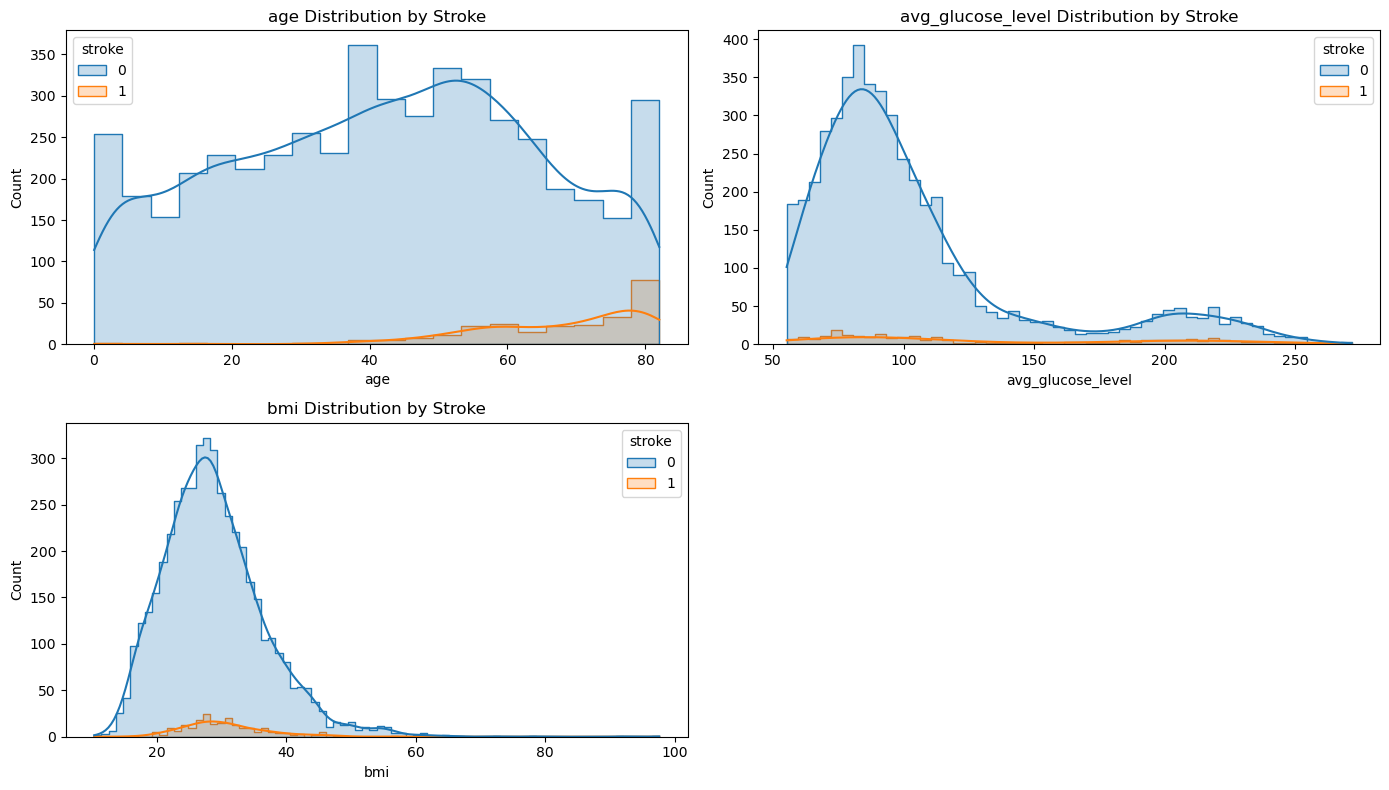

In [12]:
# plotting the distribution of numerical features across stroke data

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue="stroke", kde=True, element="step", ax=axes[i])
    axes[i].set_title(f"{col} Distribution by Stroke")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* **Age Distribution by Stroke:** Stroke cases are skewed toward older ages, suggesting that the likelihood of stroke increases with age.

* **Average Glucose Level Distribution by Stroke:** Most patients have an average glucose level between 80-100. Stroke cases appear more concentrated around the mid-70s range, though the distinction is less pronounced.

* **BMI Distribution by Stroke:** BMI is fairly normal distributed across patients, with stroke cases peaking around a BMI of 30.


To get a better understanding of these features and their relation to stroke, we can group them and observed their general behaviour.


In [13]:
df['age_group'] = pd.cut(df['age'], bins=range(0, 101, 10))
df['avg_glucose_level_group'] = pd.cut(df['avg_glucose_level'], bins=range(0, 301, 10))
df['bmi_group'] = pd.cut(df['bmi'], bins=range(0, 101, 5))

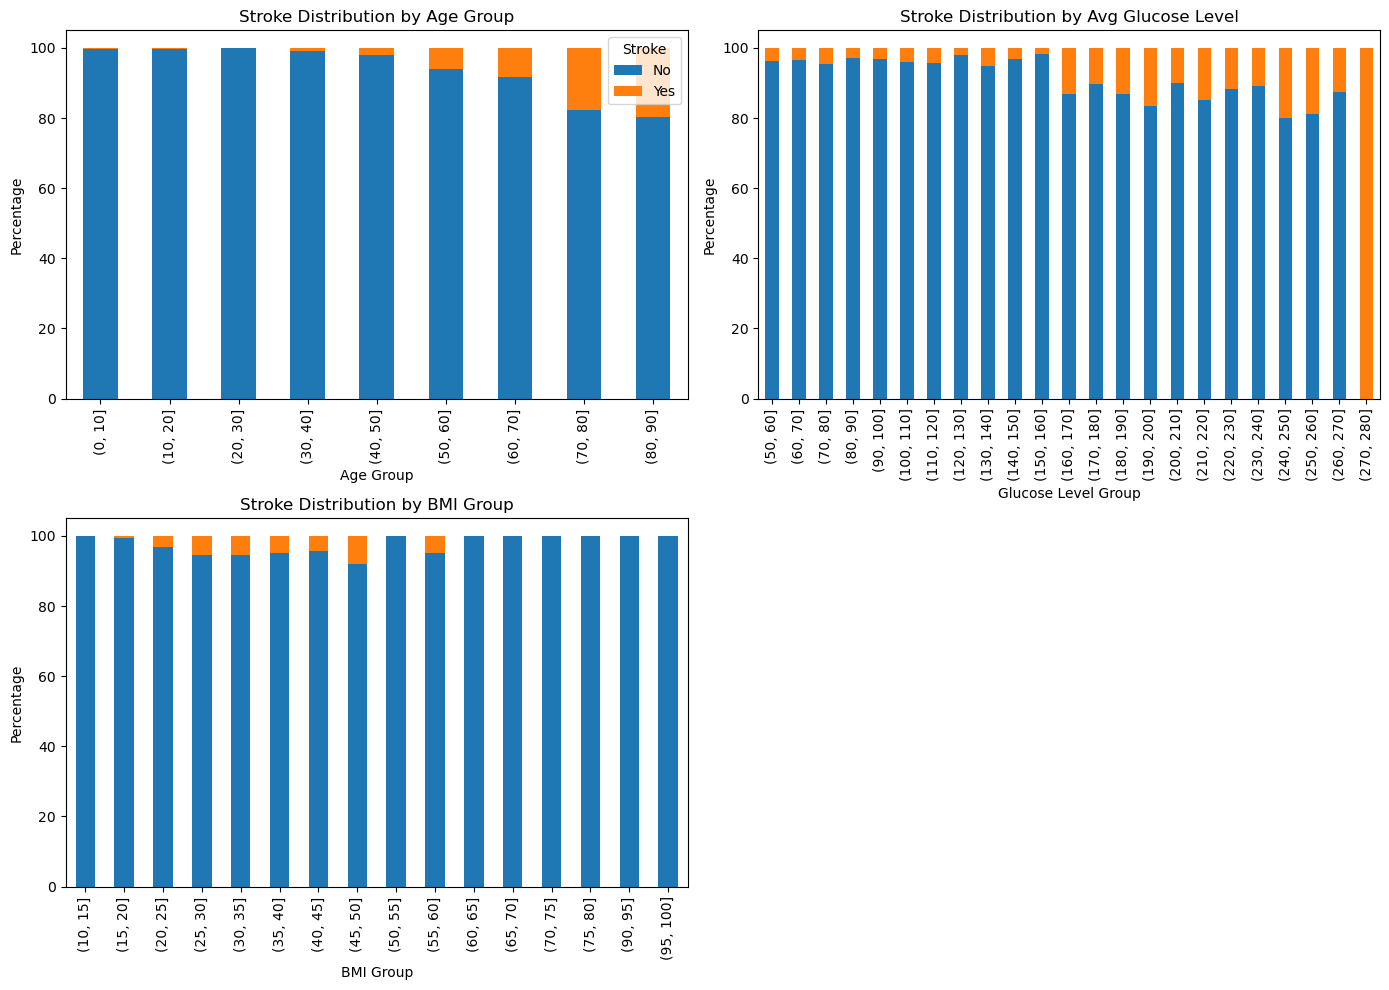

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# plot age
stroke_counts = pd.crosstab(df['age_group'], df['stroke'], normalize='index') * 100
stroke_counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Stroke Distribution by Age Group")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Age Group")
axes[0].legend(title="Stroke", labels=["No", "Yes"])

# plot glucose leveks
stroke_counts = pd.crosstab(df['avg_glucose_level_group'], df['stroke'], normalize='index') * 100
stroke_counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Stroke Distribution by Avg Glucose Level")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Glucose Level Group")
axes[1].legend().remove()

# plot BMI
stroke_counts = pd.crosstab(df['bmi_group'], df['stroke'], normalize='index') * 100
stroke_counts.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_title("Stroke Distribution by BMI Group")
axes[2].set_ylabel("Percentage")
axes[2].set_xlabel("BMI Group")
axes[2].legend().remove()

fig.delaxes(axes[3])
plt.tight_layout()
plt.show()


* **Age Group vs. Stroke**

    * Stroke prevalence **increases significantly with age**.
    * Very low stroke rates are observed in patients under 40.
    * Stroke risk becomes more visible in the **50+ group**, and especially high in **70-80** and **80-90** groups.

* **Average Glucose Level vs. Stroke**

    * Most patients fall within the **80–120 glucose level range**, with relatively few strokes.
    * Stroke prevalence rises in **higher glucose ranges (>150)**.
    * The stroke rate is especially elevated in the **200+ glucose level** groups, suggesting a strong link between elevated glucose and stroke risk.


* **BMI vs. Stroke**

    * Stroke prevalence is **highest in BMI ranges of 25-35**, corresponding to overweight/obese categories.
    * Below BMI 20, there are very few stroke cases.
    * At higher BMI values (>40), the stroke rate is less clear due to fewer samples, but no strong upward trend is observed.


Essentially, it can be said that **Age** and **high glucose levels** are strong predictors of stroke. **BMI** shows moderate influence, with higher risk clustering around overweight ranges (25–-5).

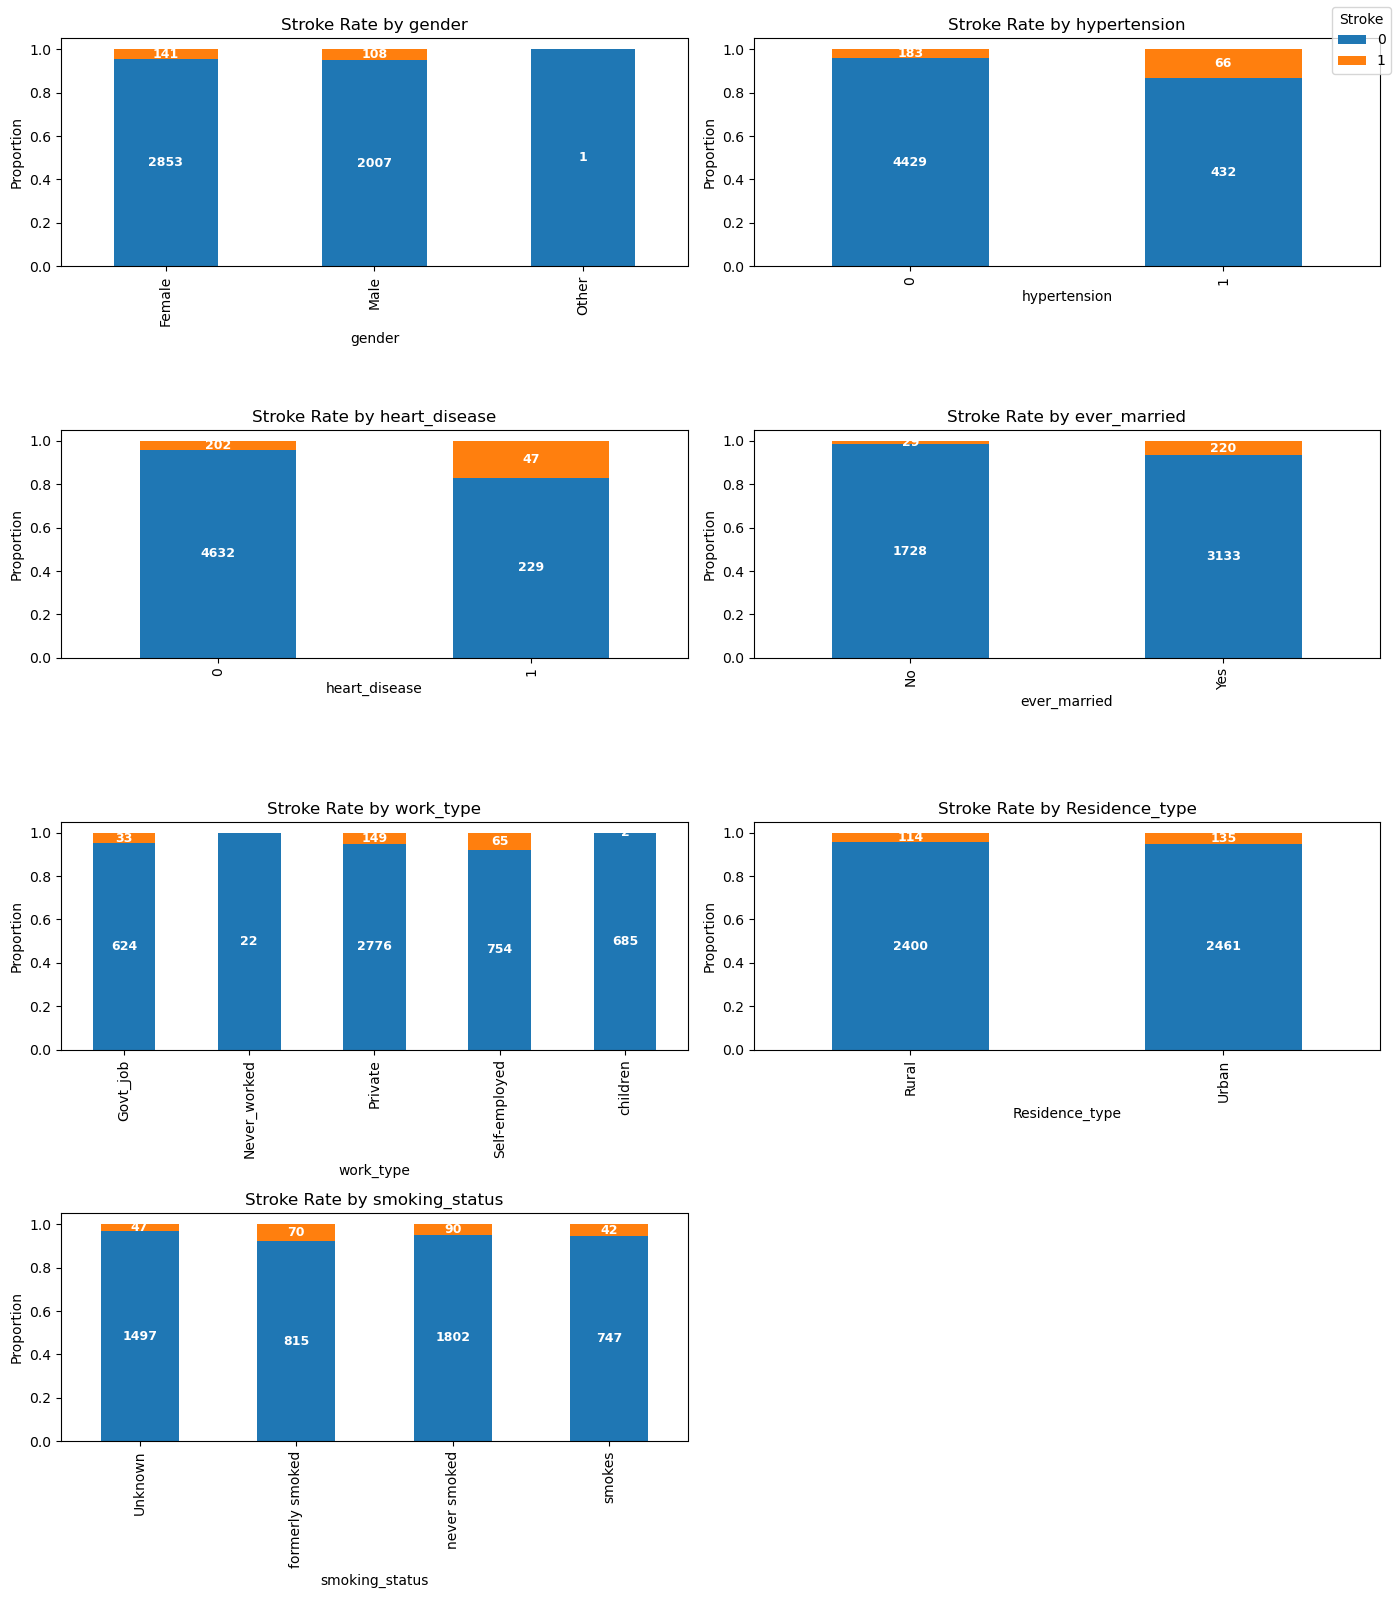

In [15]:
# plotting the count and proportion of stroke for each category of ordinal fields

fig, axes = plt.subplots(4, 2, figsize=(14, 16)) # 2 plot in 4 rows
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # counts + proportions
    counts = pd.crosstab(df[col], df["stroke"])  # raw counts
    cross = counts.div(counts.sum(axis=1), axis=0)  # normalized proportions
    
    # plot stacked bar (proportions)
    ax = cross.plot(kind="bar", stacked=True, ax=axes[i], legend=False)
    axes[i].set_title(f"Stroke Rate by {col}")
    axes[i].set_ylabel("Proportion")
    
    # annotating bars with counts
    for idx, cat in enumerate(counts.index):
        bottom = 0
        for stroke_val in counts.columns:
            count_val = counts.loc[cat, stroke_val]
            prop_val = cross.loc[cat, stroke_val]
            if count_val > 0:
                ax.text(
                    idx, # feature columns
                    bottom + prop_val/2,           
                    str(count_val),  # count per stroke value
                    ha="center", va="center", fontsize=9, color="white", weight="bold"
                )
            bottom += prop_val

fig.legend(title="Stroke", labels=counts.columns, loc="upper right")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* **Stroke Rate by Gender:** The dataset contains three gender categories: *Female* (largest group), *Male*, and a single record labeled *Other*. Stroke prevalence among both males and females is around 5%. The lone "Other" entry is not a stroke patient, so we may consider removing it since it adds no predictive value.

* **Stroke Rate by Hypertension:** Most patients do not have hypertension (4612 vs. 498 with hypertension). However, stroke prevalence is higher among patients with hypertension (13%) compared to those without (4%), even though the absolute number of stroke patients is larger in the non-hypertensive group (183 vs. 66).

* **Stroke Rate by Heart Disease:** Most patients do not have heart disease, but stroke prevalence is higher among those with a history of heart disease (17% vs. 4%).

* **Stroke Rate by Marital Status:** Most patients are married, and stroke prevalence is higher in this group compared to unmarried patients.

* **Stroke Rate by Work Type:** There are five work categories, with *Private* being the most common and *Never Worked* the least. Most stroke cases are found among patients working in the private sector or self-employed. No strokes were observed among those who never worked, and only two stroke cases occurred in children. 

* **Stroke Rate by Residence Type:** Patients are fairly evenly split between urban and rural areas, with no significant difference in stroke prevalence between the two.

* **Stroke Rate by Smoking Status:** Of the four smoking categories, stroke prevalence is highest among those who *formerly smoked*. However, most patients in the dataset never smoked, with about 5% of them experiencing stroke.

Still, we see that there are less people with stroke history across the different categories.



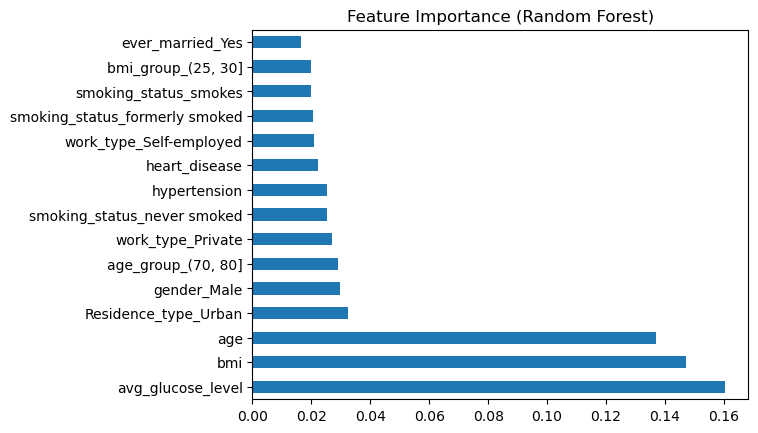

In [16]:
# using feature importance computed from the random forest classifier
X = df.drop(columns=["stroke"])
X = pd.get_dummies(X, drop_first=True)  # encode categoricals
y = df["stroke"]

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(15).plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.show()


This chart shows **feature importance** from a Random Forest model predicting stroke, we can see from it that average glucose level, age, and BMI are the most influential predictors of stroke, with glucose level being the strongest. Demographic factors such as residence type and gender showed moderate importance, while variables like smoking status, hypertension, heart disease, surprisingly contribute less. This suggests that, within the dataset, metabolic factors and age are the primary drivers of stroke prediction, though lower-ranked features may still hold relevance.



### Avoiding Bias by Dropping Duplicates and Imbalanced data

In [17]:
print(df[df.duplicated()])

Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke, age_group, avg_glucose_level_group, bmi_group]
Index: []


No duplicates to drop, however...

In [18]:
raw_df.loc[raw_df.gender=="Other",:]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


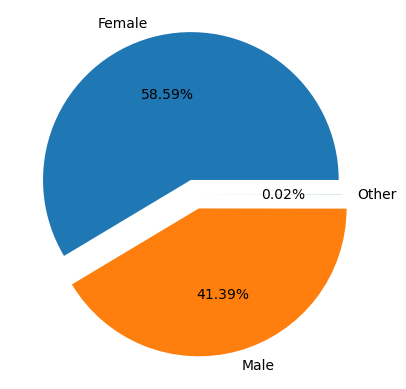

In [19]:
plt.pie(df.gender.value_counts(),labels=df.gender.value_counts().index,autopct='%1.2f%%',explode=[0.1,0.1,0])
plt.show()

Coming back to the singular record of gender = 'Other', we aim to retain as much stroke-related data as possible given the dataset is relatively small and already imbalanced (favoring patients without stroke). However, this particular patient **does not** have hypertension, heart disease, or a history of **stroke**. While their average glucose level is above average and their smoking status is "formerly smoked" (factors that are strongly and moderately associated with some stroke cases), they do not belong to the target class (stroke = 1).

Including this row adds a third category to the 'gender' feature, **increasing model complexity unnecessarily**. With only 1 out of 5110 records (≈ 0.02%), the 'Other' category is statistically insignificant and provides no contribution to stroke prediction. Additionally, the presence of a unique category increases the risk of overfitting, as the model may assign disproportionate importance to this lone record.

 **Conclusion: Drop single 'Other' gender**

In [20]:
df = df.loc[df.gender!="Other",:]

In [21]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

### Filling NA Values

In [22]:
raw_df['stroke'][raw_df['bmi'].isna()].value_counts()

stroke
0    161
1     40
Name: count, dtype: int64

In [23]:
raw_df.loc[raw_df['stroke'] == 1, 'bmi'].isna().mean()

0.1606425702811245

#### Fill NaN BMI values using the smart mean considering the age and gender of patient

There are **201 missing patient BMI**. Of this, **40 patients had a record of Stroke**. It would be detrimental to drop these so we will attempt to fill this. Since this is the body mass index of a patient, we use an imputation strategy based on gender and age by smartly assign the closest mean BMI based on the gender and age of the patient to avoid losing the already limit stroke = 1 data.

In [24]:
df.groupby(["gender", "age"])["bmi"].mean()

gender  age  
Female  0.08     14.100000
        0.32     17.266667
        0.40     17.400000
        0.48     16.100000
        0.56     18.300000
                   ...    
Male    78.00    27.247222
        79.00    27.681818
        80.00    29.210714
        81.00    27.677273
        82.00    27.943478
Name: bmi, Length: 205, dtype: float64

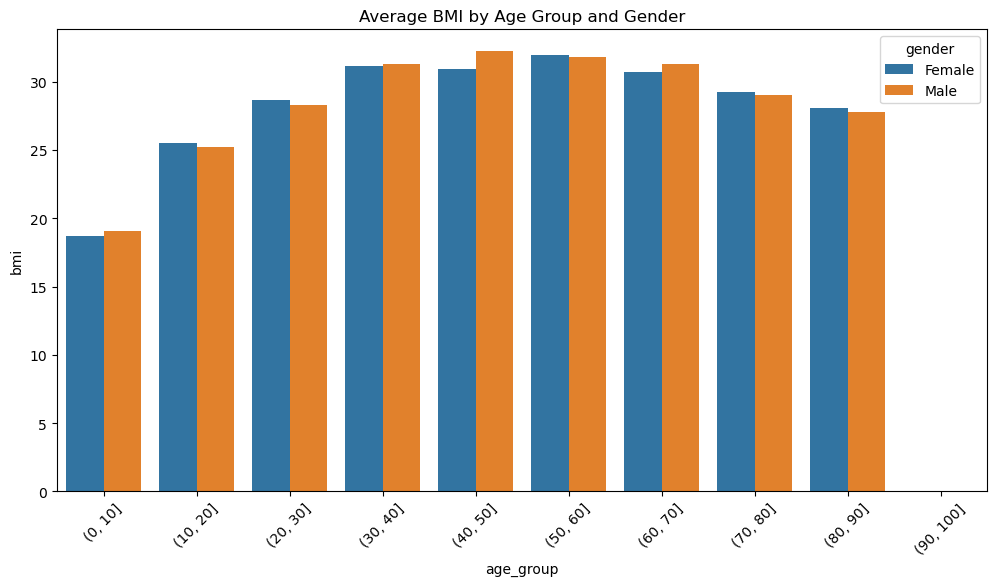

In [25]:
# Compute mean BMI per age group and gender
grouped = df.groupby(['age_group', 'gender'])['bmi'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='age_group', y='bmi', hue='gender')
plt.title("Average BMI by Age Group and Gender")
plt.xticks(rotation=45)
plt.show()


In [26]:
df.loc[df.bmi.isna(),["age","gender"]]

,age,gender
id,,
51676,61.0,Female
27419,59.0,Female
8213,78.0,Male
25226,57.0,Male
61843,58.0,Male
...,...,...
42007,41.0,Male
28788,40.0,Male
32235,45.0,Female


In [27]:
# Get the average bmi per gender and age
average_bmi = df.groupby(["gender","age"])["bmi"].mean().astype(float).to_dict()

In [28]:
any(pd.isna(bmi) for bmi in average_bmi.values()) # checking for na values in bmi group

True

In [29]:
# dropping any missing bmi from the dictionary
nan_bmi = [k for k, v in average_bmi.items() if pd.isna(v)]

for k in nan_bmi:
     del average_bmi[k]

any(pd.isna(bmi) for bmi in average_bmi.values())

False

In [30]:
def bmi_mapper(gender, age):
    """
    Returns the closest BMI associated to gender and age.

    Parameters:
        gender-> string, respresenting sex of value either "Male", "Female" or "Other"
        age-> integer, representing patient's age in years

    Returns: 
        bmi-> float
    """
    if (gender, age) in average_bmi.keys():
        return average_bmi[(gender, age)]
    else:
        available_ages = [a for g, a in average_bmi.keys() if g == gender]
        if not available_ages:
            return None
        closest_age = min(available_ages, key=lambda x: abs(x - age))
        return average_bmi[(gender, closest_age)]


In [31]:
print("State of missing values before processing")
print(df.bmi.isna().sum())
df["bmi"] = df.apply(
    lambda row: bmi_mapper(row['gender'], row['age']) if pd.isna(row['bmi']) else row['bmi'],
    axis=1
)
print("State of missing values after processing")
print(df.bmi.isna().sum())

State of missing values before processing
201
State of missing values after processing
0


In [32]:
df.isna().sum()

gender                       0
age                          0
hypertension                 0
heart_disease                0
ever_married                 0
work_type                    0
Residence_type               0
avg_glucose_level            0
bmi                          0
smoking_status               0
stroke                       0
age_group                    0
avg_glucose_level_group      0
bmi_group                  201
dtype: int64

### Encoding the Categorical Features


In [33]:
list(df.columns)

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke',
 'age_group',
 'avg_glucose_level_group',
 'bmi_group']

In [34]:
#using label encoder to encode the categorical features for the modelling step
le = LabelEncoder()
ord_feats = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
en_int = []; cat_name = [];
print('Label Encoder:')
for i in tqdm(ord_feats):
    df[i] = le.fit_transform(df[i])
    en_int.append(list(df[i].unique())); cat_name.append(list(le.inverse_transform(df[i].unique())))
    print(i,' : ',df[i].unique(),' = ',le.inverse_transform(df[i].unique()))


Label Encoder:


100%|██████████| 5/5 [00:00<00:00, 341.23it/s]

gender  :  [1 0]  =  ['Male' 'Female']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 3 0 4 1]  =  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type  :  [1 0]  =  ['Urban' 'Rural']
smoking_status  :  [1 2 3 0]  =  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [35]:
dict = {}
for i in range(len(ord_feats)):
    dict[ord_feats[i]] = {}
    for j,k in zip(en_int[i],cat_name[i]):
        dict[ord_feats[i]][j] = k

dict['hypertension'] = {0 : 'No Hypertension', 1 : 'Hypertension'} 
dict['heart_disease'] = {0 : 'No Heart Disease', 1 : 'Heart Disease'}
dict

{'gender': {1: 'Male', 0: 'Female'},
 'ever_married': {1: 'Yes', 0: 'No'},
 'work_type': {2: 'Private',
  3: 'Self-employed',
  0: 'Govt_job',
  4: 'children',
  1: 'Never_worked'},
 'Residence_type': {1: 'Urban', 0: 'Rural'},
 'smoking_status': {1: 'formerly smoked',
  2: 'never smoked',
  3: 'smokes',
  0: 'Unknown'},
 'hypertension': {0: 'No Hypertension', 1: 'Hypertension'},
 'heart_disease': {0: 'No Heart Disease', 1: 'Heart Disease'}}

In [36]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,avg_glucose_level_group,bmi_group
id,,,,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1,"(60, 70]","(220, 230]","(35.0, 40.0]"
51676,0,61.0,0,0,1,3,0,202.21,29.879487,2,1,"(60, 70]","(200, 210]",NaN
31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1,"(70, 80]","(100, 110]","(30.0, 35.0]"
60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1,"(40, 50]","(170, 180]","(30.0, 35.0]"
1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1,"(70, 80]","(170, 180]","(20.0, 25.0]"


### Balancing Data with SMOTE

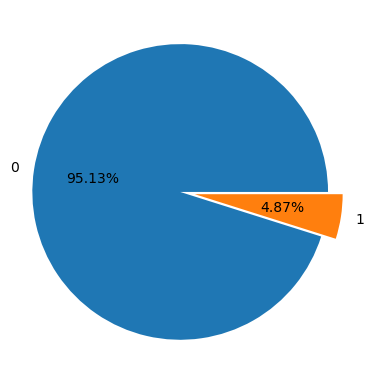

In [37]:
plt.pie(df.stroke.value_counts(),labels=df.stroke.value_counts().index,autopct='%1.2f%%',explode=[0.1,0])
plt.show()

We can see the data is unbalanced as less than 5% of the data respresents patients with stroke. As such we will try to balance the data using SMOTE. We will try to oversample with SMOTE, increasing the minority class, and random undersample, cutting down the majority class, for imbalanced dataset.

In [38]:
df.stroke.value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

In [39]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'avg_glucose_level_group',
       'bmi_group'],
      dtype='object')

In [40]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
X = df.loc[:,:'smoking_status']
y = df.loc[:,'stroke']

steps = [('u', under),('o', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
Counter(y)

Counter({0: 2490, 1: 2490})

Given:


  $$
  \text{Sampling Strategy} = \frac{\text{Minority Class Samples}}{\text{Majority Class Samples}}
  $$

In this approach, we first reduced the majority class through undersampling to 2,490 non-stroke cases, achieving a manageable ratio of 0.1. We then applied oversampling with SMOTE to increase the minority class to 2,490 stroke cases, resulting in a balanced dataset of 2,490 samples per class. 


## Modelling

### Splitting Data

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [42]:
print(f'Training Features: {len(x_train)}\nTesting Features: {len(x_test)}\nTraining target: {len(y_train)}\nTesting target: {len(y_test)}')


Training Features: 3984
Testing Features: 996
Training target: 3984
Testing target: 996


In [43]:
print(f'Training Features:\n{x_train.mean()}\nTesting Features:\n{x_test.mean()}\nTraining target:\n{y_train.mean()}\nTesting target:\n{y_test.mean()}')


Training Features:
gender                 0.332078
age                   54.888991
hypertension           0.087349
heart_disease          0.053213
ever_married           0.728916
work_type              1.965612
Residence_type         0.407380
avg_glucose_level    118.904712
bmi                   29.642073
smoking_status         1.293926
dtype: float64
Testing Features:
gender                 0.305221
age                   55.570445
hypertension           0.082329
heart_disease          0.052209
ever_married           0.722892
work_type              1.941767
Residence_type         0.442771
avg_glucose_level    115.906571
bmi                   29.636653
smoking_status         1.269076
dtype: float64
Training target:
0.49899598393574296
Testing target:
0.5040160642570282


### Trail 1

### Logistic Regression

In [44]:
lr_model = LogisticRegression(random_state=3,max_iter=1000)

In [45]:
lr_model.fit(X=x_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=3)

In [46]:
y_test_predicted = lr_model.predict(x_test)
y_test_prob = lr_model.predict_proba(x_test)[:,1]

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)

In [49]:
print("---Logistic Regression Results---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_predicted))
print("\nClassification Report:\n", classification_report(y_test, y_test_predicted))
print("\nROC AUC:", roc_auc_score(y_test, y_test_prob))

---Logistic Regression Results---
Confusion Matrix:
 [[376 118]
 [ 96 406]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       494
           1       0.77      0.81      0.79       502

    accuracy                           0.79       996
   macro avg       0.79      0.78      0.78       996
weighted avg       0.79      0.79      0.78       996


ROC AUC: 0.8592391567333904


### Decision Tree

In [50]:
dt_model = DecisionTreeClassifier()

In [51]:
dt_model.fit(X=x_train,y=y_train)

DecisionTreeClassifier()

In [52]:
y_test_predicted_dt = dt_model.predict(x_test)
y_test_prob_dt = dt_model.predict_proba(x_test)[:,1]

In [53]:
print("---Decision Tree Results---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_predicted_dt))
print("\nClassification Report:\n", classification_report(y_test, y_test_predicted_dt))
print("\nROC AUC:", roc_auc_score(y_test, y_test_prob_dt))

---Decision Tree Results---
Confusion Matrix:
 [[418  76]
 [ 60 442]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       494
           1       0.85      0.88      0.87       502

    accuracy                           0.86       996
   macro avg       0.86      0.86      0.86       996
weighted avg       0.86      0.86      0.86       996


ROC AUC: 0.8633159669016244


### Random Forest

In [54]:
rf_model = RandomForestClassifier()

In [55]:
rf_model.fit(X=x_train,y=y_train)

RandomForestClassifier()

In [56]:
y_test_predicted_rf = rf_model.predict(x_test)
y_test_prob_rf = rf_model.predict_proba(x_test)[:,1]

In [57]:
print("---Random Forest Results---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_predicted_rf))
print("\nClassification Report:\n", classification_report(y_test, y_test_predicted_rf))
print("\nROC AUC:", roc_auc_score(y_test, y_test_prob_rf))

---Random Forest Results---
Confusion Matrix:
 [[434  60]
 [ 35 467]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       494
           1       0.89      0.93      0.91       502

    accuracy                           0.90       996
   macro avg       0.91      0.90      0.90       996
weighted avg       0.91      0.90      0.90       996


ROC AUC: 0.9670447763601464


In [59]:
# k-mean cross validation on random forest model
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)
print("Mean ROC AUC:", cv_scores.mean())

Cross-validation ROC AUC scores: [0.93348898 0.98082692 0.98205472 0.9868611  0.98235311]
Mean ROC AUC: 0.9731169658553893


In [60]:
# checking misclassification in random forest model
x_test_df = pd.DataFrame(x_test, columns=X.columns)

# combine features with actual and predicted labels
full_results = x_test_df.copy()
full_results['actual'] = y_test
full_results['predicted'] = y_test_predicted_rf

# filter incorrect predictions
incorrect_full = full_results[full_results['actual'] != full_results['predicted']]


incorrect_full_mapped = incorrect_full.copy()
for col, mapping in dict.items():
    if col in incorrect_full_mapped.columns:
        incorrect_full_mapped[col] = incorrect_full_mapped[col].map(mapping)

# # the misclassified rows with actual features
# print(incorrect_full_mapped)

In [61]:
# remapping values to read them
for col in cat_cols:
    most_common = incorrect_full_mapped[col].value_counts().idxmax()
    count = incorrect_full_mapped[col].value_counts().max()
    print(f"{col}: Most misclassified value = {most_common} ({count} cases)")

for col in num_cols:
    bins = 5 
    most_common_bin = pd.cut(incorrect_full_mapped[col], bins=bins).value_counts().idxmax()
    count = pd.cut(incorrect_full_mapped[col], bins=bins).value_counts().max()
    print(f"{col}: Most misclassified range = {most_common_bin} ({count} cases)")

gender: Most misclassified value = Female (66 cases)
hypertension: Most misclassified value = No Hypertension (82 cases)
heart_disease: Most misclassified value = No Heart Disease (87 cases)
ever_married: Most misclassified value = Yes (81 cases)
work_type: Most misclassified value = Private (57 cases)
Residence_type: Most misclassified value = Rural (49 cases)
smoking_status: Most misclassified value = never smoked (40 cases)
age: Most misclassified range = (65.928, 82.0] (42 cases)
avg_glucose_level: Most misclassified range = (59.88, 100.779] (51 cases)
bmi: Most misclassified range = (24.7, 32.1] (53 cases)


### Trail 2: Removing Outliers

Using the Interquartile range to to drop lower contributing feature points or outliers. 
https://en.wikipedia.org/wiki/Interquartile_range

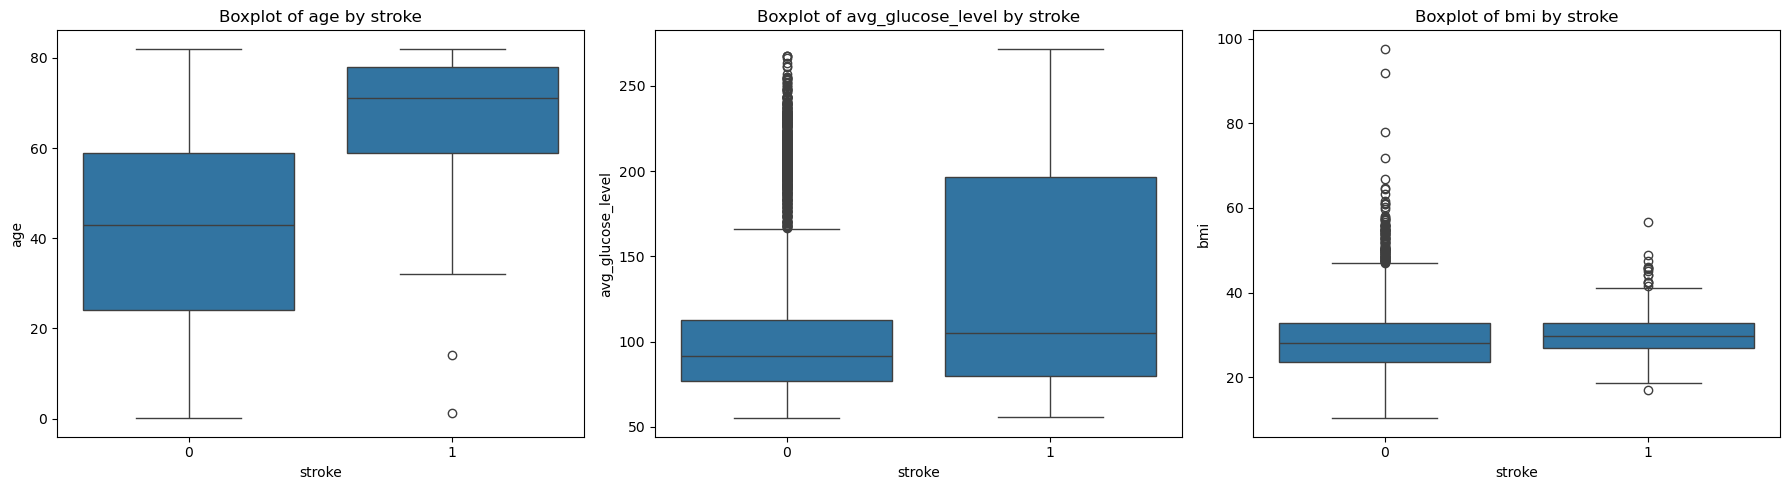

age | Stroke=1 | Lower whisker: 30.50, Upper whisker: 106.50, Outliers count: 2
age | Stroke=0 | Lower whisker: -28.50, Upper whisker: 111.50, Outliers count: 0
avg_glucose_level | Stroke=1 | Lower whisker: -95.59, Upper whisker: 372.09, Outliers count: 0
avg_glucose_level | Stroke=0 | Lower whisker: 23.60, Upper whisker: 166.32, Outliers count: 552
bmi | Stroke=1 | Lower whisker: 18.30, Upper whisker: 41.50, Outliers count: 15
bmi | Stroke=0 | Lower whisker: 9.40, Upper whisker: 47.00, Outliers count: 114


In [62]:
# separate by target class
stroke_classes = df['stroke'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_cols):
    sns.boxplot(x='stroke', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by stroke')

plt.tight_layout()
plt.show()

# IQR method for outlier counts 
for col in num_cols:
    for cls in stroke_classes:
        cls_data = df[df['stroke'] == cls][col]
        Q1 = cls_data.quantile(0.25)
        Q3 = cls_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_whisker = Q1 - 1.5*IQR
        upper_whisker = Q3 + 1.5*IQR
        outliers = cls_data[(cls_data < lower_whisker) | (cls_data > upper_whisker)]
        print(f'{col} | Stroke={cls} | Lower whisker: {lower_whisker:.2f}, Upper whisker: {upper_whisker:.2f}, Outliers count: {len(outliers)}')


In [63]:
for col in num_cols:
    for cls in stroke_classes:
        # filtering the stroke & non stroke data for capping outliers
        cls_idx = df['stroke'] == cls
        cls_data = df.loc[cls_idx, col]
        
        # compute IQR and whiskers
        Q1 = cls_data.quantile(0.25)
        Q3 = cls_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_whisker = Q1 - 1.5*IQR
        upper_whisker = Q3 + 1.5*IQR
        
        # cap values outside whiskers
        df.loc[cls_idx, col] = cls_data.clip(lower=lower_whisker, upper=upper_whisker)

print("Outliers capped using 1.5*IQR method per stroke class.")

Outliers capped using 1.5*IQR method per stroke class.


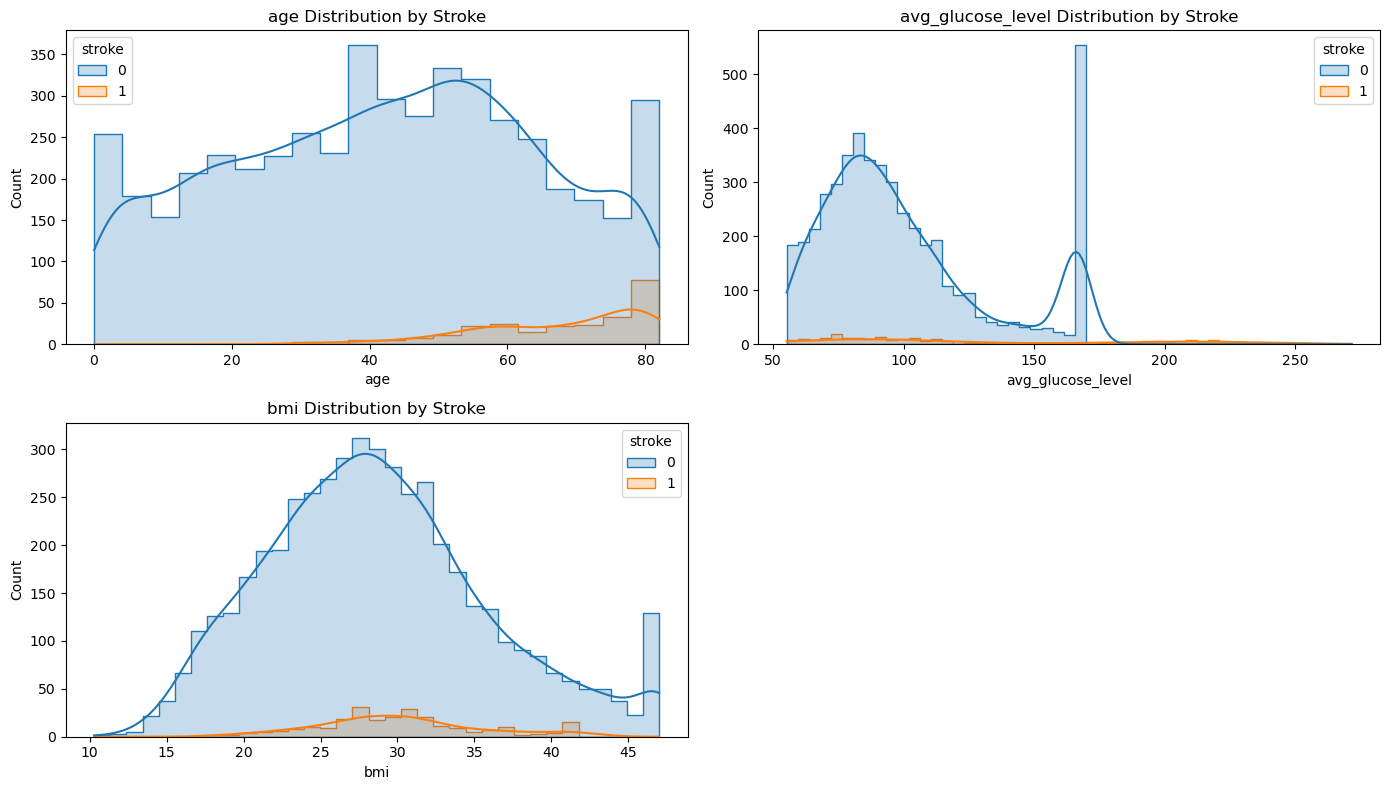

In [64]:
#replotting distribution of numerical columns
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue="stroke", kde=True, element="step", ax=axes[i])
    axes[i].set_title(f"{col} Distribution by Stroke")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [65]:
#rebalancing dataset
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
X = df.loc[:,:'smoking_status']
y = df.loc[:,'stroke']

steps = [('u', under),('o', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
Counter(y)

Counter({0: 2490, 1: 2490})

In [66]:
# resplitting dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

### Random Forest

In [67]:
rf_model2 = RandomForestClassifier()

In [68]:
rf_model2.fit(X=x_train,y=y_train)

RandomForestClassifier()

In [69]:
y_test_predicted_rf2 = rf_model2.predict(x_test)
y_test_prob_rf2 = rf_model2.predict_proba(x_test)[:,1]

In [70]:
print("---Random Forest Results From Trail 2---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_predicted_rf2))
print("\nClassification Report:\n", classification_report(y_test, y_test_predicted_rf2))
print("\nROC AUC:", roc_auc_score(y_test, y_test_prob_rf2))

---Random Forest Results From Trail 2---
Confusion Matrix:
 [[465  29]
 [ 30 472]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       494
           1       0.94      0.94      0.94       502

    accuracy                           0.94       996
   macro avg       0.94      0.94      0.94       996
weighted avg       0.94      0.94      0.94       996


ROC AUC: 0.9877272287368744


In [71]:
cv_scores2 = cross_val_score(rf_model2, X, y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores2)
print("Mean ROC AUC:", cv_scores2.mean())

Cross-validation ROC AUC scores: [0.9680489  0.98860905 0.99102434 0.9907562  0.99201223]
Mean ROC AUC: 0.9860901437073595


**Observation**: We see the the accuracy and ROC AUC slightly improved in our best performing model, the random forest, when the outliers in the features are removing considering the target class.

### Conclusion 

Among the three models, Random Forest clearly delivered the strongest performance especially when outliers were removed, achieving the highest accuracy (94%), the best balance between precision and recall, and an outstanding ROC AUC of 0.98, indicating excellent discrimination between stroke and non-stroke cases. While Logistic Regression and Decision Tree models both performed reasonably well with accuracy around 79-86% and ROC AUC of 0.85-0.96, they misclassified more cases compared to Random Forest. Logistic Regression remains valuable for its interpretability, making it suitable when model transparency is required, whereas Decision Trees offer a simple but slightly stronger alternative. Overall, Random Forest stands out as the most reliable model for stroke prediction, particularly due to its superior ability to correctly identify stroke cases with high recall, which is crucial in a medical context.
